In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torchvision
from torchvision import datasets, transforms
import torch.utils
import torch.utils.data 
import torch.utils.data.dataloader
import torchvision.models.resnet

from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score
from itertools import groupby

In [2]:
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.4.0


In [3]:
print(f"Is MPS built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Is MPS built? True
Is MPS available? True
Using device: mps


In [4]:
def validate(model, loader):
    correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            # Send data to device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    return correct / total

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import Image

# 2. Laden des model Modells ohne vortrainierte Gewichte
# CNN Architectures
#model = models.alexnet()
#model = models.resnet50(models.ResNet50_Weights.DEFAULT)
#model = models.vgg16()
#model = models.vit_h_14(weights= models.ViT_H_14_Weights.DEFAULT) # -> not working
#model = models.vit_l_16(weights=models.ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1) -> not working
#model = models.vit_h_14()
#model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)
#model = models.regnet_y_3_2gf()
model = models.vgg16()


model = model.to(device)

# 3. & 4. Datensatz vorbereiten und in Trainings- und Validierungssets aufteilen
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 5. Laden des Datensatzes

# Absoluter Pfad basierend auf dem aktuellen Arbeitsverzeichnis
#parent_directory = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Relative path to the folder containing the images
relative_folderpath = '/Volumes/Crucial X9/Data_MT/Various Smule Vocal Performances/DB/Batch 3/vocal_org/graph/spec'

# Erstellen des Datasets
dataset = datasets.ImageFolder(relative_folderpath, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

random_seed = 2024
torch.manual_seed(random_seed)

# Define the sizes of the train and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print('Train Dataset: ' + str(len(train_dataset)))
print('Validation Dataset: ' + str(len(val_dataset)))
print('Test Dataset: ' + str(len(test_dataset)))


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

# 6. Verlustfunktion und Optimierer definieren
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

#num_epochs = 100  # Setzen Sie eine hohe Anzahl von Epochen
#patience = 10  # Anzahl der Epochen ohne Verbesserung, bevor das Training gestoppt wird
#best_val_loss = float('inf')
#epochs_no_improve = 0

acc = []
loss_values = []

# 7. Trainingsschleife mit Validierung
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    train_accuracy = validate(model, val_loader)
    
    loss_values.append(loss.item())
    acc.append(train_accuracy)

    print(f'Epoch: {epoch + 1} | Loss: {loss.item()} | Train Accuracy:  {train_accuracy}')

    '''
    val_loss /= len(val_loader)
    print(f'Epoch: {epoch + 1} | Validation Loss: {val_loss}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print('Early stopping!')
        break
    '''

# Laden Sie das beste Modell
#model.load_state_dict(torch.load('best_model.pth'))


Valid images: []
Train Dataset: 1976
Validation Dataset: 247
Test Dataset: 248


UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/Users/davidpichler/GitHubRepo/Thesis/.conda/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/davidpichler/GitHubRepo/Thesis/.conda/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/davidpichler/GitHubRepo/Thesis/.conda/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 420, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/davidpichler/GitHubRepo/Thesis/.conda/lib/python3.11/site-packages/torch/utils/data/dataset.py", line 420, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "/Users/davidpichler/GitHubRepo/Thesis/.conda/lib/python3.11/site-packages/torchvision/datasets/folder.py", line 245, in __getitem__
    sample = self.loader(path)
             ^^^^^^^^^^^^^^^^^
  File "/Users/davidpichler/GitHubRepo/Thesis/.conda/lib/python3.11/site-packages/torchvision/datasets/folder.py", line 284, in default_loader
    return pil_loader(path)
           ^^^^^^^^^^^^^^^^
  File "/Users/davidpichler/GitHubRepo/Thesis/.conda/lib/python3.11/site-packages/torchvision/datasets/folder.py", line 263, in pil_loader
    img = Image.open(f)
          ^^^^^^^^^^^^^
  File "/Users/davidpichler/GitHubRepo/Thesis/.conda/lib/python3.11/site-packages/PIL/Image.py", line 3498, in open
    raise UnidentifiedImageError(msg)
PIL.UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='/Volumes/Crucial X9/Data_MT/Various Smule Vocal Performances/DB/Batch 3/vocal_org/graph/spec/original/._76571844_41393408_10.png'>


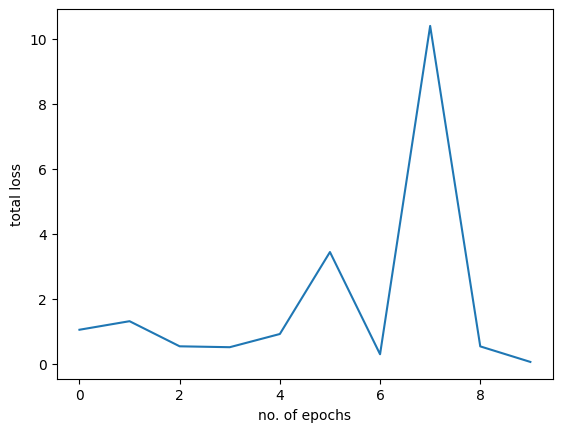

In [ ]:
plt.plot(loss_values)
plt.xlabel("no. of epochs")
plt.ylabel("total loss")
plt.show()

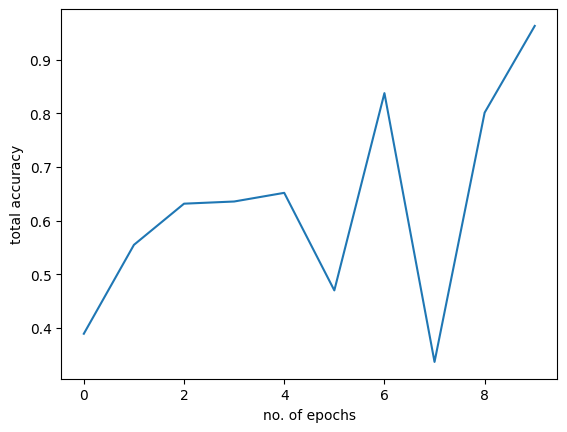

In [ ]:
plt.plot(acc)
plt.xlabel("no. of epochs")
plt.ylabel("total accuracy")
plt.show()

In [ ]:
model.eval()

with torch.no_grad():
   correct = 0
   total = 0
   true_labels = []
   predicted_labels = []

   for X_test_tensor, Y_test_tensor in test_loader:
      X_test_tensor, Y_test_tensor = X_test_tensor.to(device), Y_test_tensor.to(device)
      outputs = model(X_test_tensor)
      _, predicted = torch.max(outputs.data, 1)

      y_test = Y_test_tensor.cpu().numpy()
      predicted = predicted.cpu().numpy()

      correct += (predicted == y_test).sum().item()
      total += len(y_test)


      true_labels.extend(y_test)
      predicted_labels.extend(predicted)

   unique, counts = np.unique(predicted_labels, return_counts=True)
   predicted_labels_dict = {int(k): int(v) for k, v in zip(unique, counts)}
   print(f'Predicted labels: {predicted_labels_dict}')

   unique, counts = np.unique(true_labels, return_counts=True)
   true_labels_dict = {int(k): int(v) for k, v in zip(unique, counts)}
   print(f'True labels: {true_labels_dict}')

   accuracy = correct / total

   print(f'Accuracy: {accuracy}')

   f1 = f1_score(true_labels, predicted_labels, average='weighted')
   print(f'F1 Score: {f1}')

   precision = precision_score(true_labels, predicted_labels, average='weighted')
   print(f'Precision: {precision}')

   recall = recall_score(true_labels, predicted_labels, average='weighted')
   print(f'Recall: {recall}')


import pandas as pd
from sklearn.metrics import confusion_matrix

# Create a DataFrame from the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_df = pd.DataFrame(cm, index=['Actual Corrected', 'Actual Original', 'Actual Smoothed'], columns=['Predicted Corrected', 'Predicted Original', 'Predicted Smoothed'])

# Display the DataFrame
print(cm_df)


Predicted labels: {0: 85, 1: 92, 2: 71}
True labels: {0: 81, 1: 93, 2: 74}
Accuracy: 0.9354838709677419
F1 Score: 0.935386662846558
Precision: 0.9358919771412901
Recall: 0.9354838709677419
                  Predicted Corrected  Predicted Original  Predicted Smoothed
Actual Corrected                   77                   1                   3
Actual Original                     0                  90                   3
Actual Smoothed                     8                   1                  65


In [ ]:
'''
if not os.path.exists('model/'): os.makedirs('model/')
torch.save({
    'model_state_dict': model.state_dict(),
    'model_architecture': model
}, 'model/regNet_complete.pth')
'''


In [ ]:
'''
 if average_validation_loss < best_validation_loss:
            best_validation_loss = average_validation_loss
            best_model_state_dict = model.state_dict()
            print(epoch, ' saved!')
'''

"\n if average_validation_loss < best_validation_loss:\n            best_validation_loss = average_validation_loss\n            best_model_state_dict = model.state_dict()\n            print(epoch, ' saved!')\n"